In [1]:
import math

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

from models.lm import LM
from models.transformer.transformer import TransformerConfig

from data import OthelloDataset

from eval import eval

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
d_model = 512
n_layers = 8
n_heads = 8

B = 32

dropout = 0.
bias = False

lr = 5e-4 # todo : up BS and LR
lr_min = 1e-5
lr_warmup_iter = 100
lr_decay_iter = 10000 # max_iters as in chinchilla

adam_b1 = 0.9
adam_b2 = 0.95

clip_value_grad = 1.0
weight_decay = 0.1

In [4]:
ds = OthelloDataset()
loader = torch.utils.data.DataLoader(ds, batch_size=B, num_workers=0, pin_memory=True)

ds_val = OthelloDataset("data/val")
loader_val = torch.utils.data.DataLoader(ds_val, batch_size=1, num_workers=0, pin_memory=True)

In [5]:
config = TransformerConfig(d_model=d_model, n_layers=n_layers, n_heads=n_heads, dropout=dropout, bias=bias, max_len=60, flash=True)
model = LM(config, vocab_size=65).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr, betas=(adam_b1, adam_b2), weight_decay=weight_decay)

sum([p.numel() for p in model.parameters()])

/home/alex/miniconda3/envs/torch23/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


33627136

In [6]:
checkpoint = torch.load("runs/jumping-plant-20.pth", map_location=lambda storage, loc: storage.cuda(device))
model.load_state_dict({key.replace('_orig_mod.', ''): value for key, value in checkpoint['model'].items()})
optim.load_state_dict(checkpoint['optimizer'])

In [7]:
eval(model, device, n_games=50)

0.9954798331015299

In [8]:
1-0.9954798331015299

0.004520166898470124

In [7]:
# cosine with warmup (taken from @karpathy)
def get_lr(it):
    if lr_decay_iter == 0:
        return lr
    
    # 1) linear warmup for warmup_iters steps
    if it < lr_warmup_iter:
        return lr * it / lr_warmup_iter
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iter:
        return lr_min
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - lr_warmup_iter) / (lr_decay_iter - lr_warmup_iter)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return lr_min + coeff * (lr - lr_min)

In [8]:
losses = []
scaler = torch.cuda.amp.GradScaler()

In [9]:
checkpoint = torch.load('ckpt.pth', map_location= lambda storage, loc: storage.cuda(device))
model.load_state_dict(checkpoint['model'])
optim.load_state_dict(checkpoint['optimizer'])
scaler.load_state_dict(checkpoint['scaler'])

In [10]:
for iter, data in enumerate(loader):
    x, y = data
    x = x.int().to(device)
    y = y.long().to(device)

    with torch.autocast(device, torch.float16):
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=0)

    scaler.scale(loss).backward()
    scaler.unscale_(optim)
    torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=clip_value_grad)
    scaler.step(optim)
    scaler.update()
    optim.zero_grad()

    # lr decay
    lr_iter = get_lr(iter)
    for param_group in optim.param_groups:
        param_group['lr'] = lr_iter

    losses.append(loss.item())

    if iter >= 500:
        break

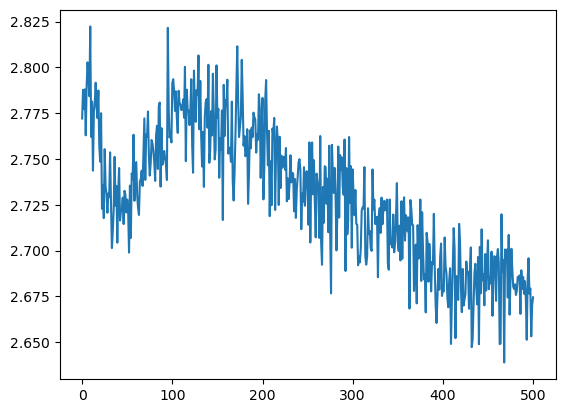

In [11]:
plt.plot(losses)

In [12]:
losses[-1]

2.674525260925293

In [12]:
checkpoint = {"model": model.state_dict(),
              "optimizer": optim.state_dict(),
              "scaler": scaler.state_dict()}
torch.save(checkpoint, "ckpt.pth")

In [11]:
# evaluate move legality

In [12]:
model.eval()

LM(
  (embedding): Embedding(65, 512, padding_idx=0)
  (core): Transformer(
    (PE): Embedding(60, 512)
    (in_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-7): 8 x DecoderLayer(
        (attention_norm): RMSNorm()
        (sa): SelfAttentionMultiHead(
          (query_proj): Linear(in_features=512, out_features=512, bias=False)
          (key_proj): Linear(in_features=512, out_features=512, bias=False)
          (value_proj): Linear(in_features=512, out_features=512, bias=False)
          (c_proj): Linear(in_features=512, out_features=512, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp_norm): RMSNorm()
        (mlp): MLP(
          (fc_1): Linear(in_features=512, out_features=2048, bias=False)
          (fc_2): Linear(in_features=2048, out_features=512, bias=False)
          (fc_3): Linear(in_features=512, out_features=2048, bias=False)
          (dropout): 

In [13]:
from eval import eval

In [14]:
eval(model, 50, loader_val)

0.21133124782759818

In [ ]:
# todo :
# .py scripts

In [4]:
from othello import OthelloGame

In [3]:
ds_val = OthelloDataset("data/val")
loader_val = torch.utils.data.DataLoader(ds_val, batch_size=1, num_workers=0, pin_memory=True)

In [10]:
n_games = 50

In [13]:
mean_legal_moves_number = 0
num_moves = 0

for i, data in enumerate(loader_val):
        game_transcript, _ = data # (1, lengame)
        game_transcript = game_transcript.squeeze().int()

        game_len = game_transcript.shape[0] # always 60-1=59 (padded)
        game = OthelloGame()
        game.play_move(game_transcript[0].item() - 1)
        for pgame_len in range(1, game_len):
            context = game_transcript[:pgame_len]

            # get legal moves given current game board
            legal_moves = game.get_valid_moves()

            mean_legal_moves_number += len(legal_moves)
            num_moves += 1

            if legal_moves == []:
                break

            game.play_move(game_transcript[pgame_len].item() - 1)
        

        if i >= n_games-1:
            break

In [15]:
mean_legal_moves_number/num_moves

8.763385146804836

In [16]:
iter = 3
num_iters = 500

In [17]:
num_digits = len(str(num_iters))
formatted_iter = f"{iter:0{num_digits}d}"

In [18]:
print(f"Step {formatted_iter}/{num_iters}")

Step 003/500


In [21]:
import random
import string

In [24]:
''.join(random.choice(string.ascii_letters) for i in range(8))

'ZnkDtRzO'

In [29]:
int(1.99)

1

In [1]:
from datasets import load_dataset

/home/alex/miniconda3/envs/torch23/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dataset = load_dataset("alexandretl/othello")

Using the latest cached version of the dataset since alexandretl/othello couldn't be found on the Hugging Face Hub


ValueError: There are multiple 'alexandretl/othello' configurations in the cache: default-37f926d00fd9e23d, default-data_dir=data%2Ftrain
Please specify which configuration to reload from the cache, e.g.
	load_dataset('alexandretl/othello', 'default-37f926d00fd9e23d')

In [4]:
dataset.save_to_disk("test")

Saving the dataset (1/1 shards): 100%|██████████| 1/1 [00:00<00:00, 284.26 examples/s]


In [10]:
dataset

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})

In [8]:
import torch

In [9]:
a = torch.ones(1, 3)

In [12]:
a[[0]].shape

torch.Size([1, 3])

In [1]:
import random

In [2]:
random.choice([3, 5, 1])

3

In [10]:
import torch

In [11]:
a = [5,3,5]

In [12]:
torch.tensor(a)

tensor([5, 3, 5])